In [1]:

import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

x_train_de = pd.read_csv('/content/x_train_de.csv')
y_train_de = pd.read_csv('/content/y_train_de.csv')
x_test_de = pd.read_csv('/content/x_test_de.csv')
y_test_de = pd.read_csv('/content/y_test_de.csv')
x_train_fr = pd.read_csv('/content/x_train_fr.csv')
y_train_fr = pd.read_csv('/content/y_train_fr.csv')
x_test_fr = pd.read_csv('/content/x_test_fr.csv')
y_test_fr = pd.read_csv('/content/y_test_fr.csv')

In [3]:

columns_to_drop = ['COUNTRY','ID','DAY_ID']

x_train_fr.drop(columns=columns_to_drop, inplace=True)
x_train_de.drop(columns=columns_to_drop, inplace=True)

x_test_fr.drop(columns=columns_to_drop, inplace=True)
x_test_de.drop(columns=columns_to_drop, inplace=True)

cols_to_fill = ['FR_DE_EXCHANGE', 'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_RAIN', 'FR_RAIN', 'DE_WIND', 'FR_WIND', 'DE_TEMP', 'FR_TEMP']

x_train_fr[cols_to_fill] = x_train_fr[cols_to_fill].fillna(x_train_fr[cols_to_fill].median())
x_train_de[cols_to_fill] = x_train_de[cols_to_fill].fillna(x_train_de[cols_to_fill].median())

x_test_fr[cols_to_fill] = x_test_fr[cols_to_fill].fillna(x_test_fr[cols_to_fill].median())
x_test_de[cols_to_fill] = x_test_de[cols_to_fill].fillna(x_test_de[cols_to_fill].median())

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

Combined MSE with best parameters: 0.4699657731975763
Combined Spearman Correlation between actual and predicted values: 0.279443606664209


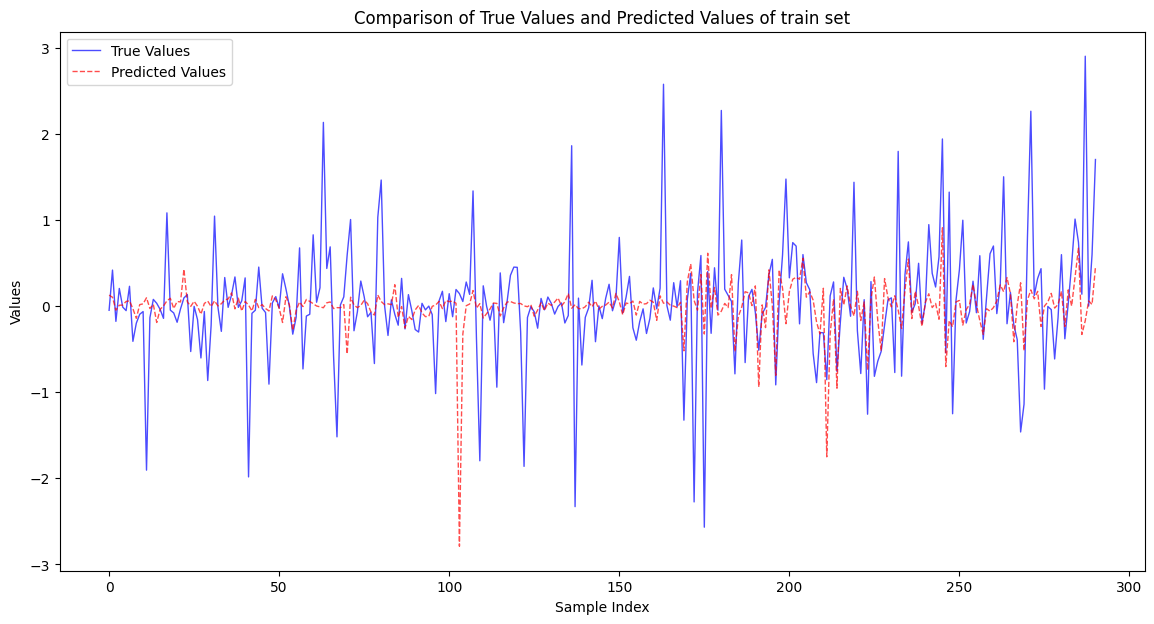

In [7]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

# Scale the data
scaler = StandardScaler()
x_train_fr_encoded_std = scaler.fit_transform(x_train_fr)
x_test_fr_std = scaler.transform(x_test_fr)
x_train_de_encoded_std = scaler.fit_transform(x_train_de)
x_test_de_std = scaler.transform(x_test_de)

y_train_fr_target = y_train_fr['TARGET'].values
y_train_de_target = y_train_de['TARGET'].values

outlier_indices = np.where((y_train_fr_target < -3) | (y_train_fr_target > 3))[0]
X_train_fr_filtered = np.delete(x_train_fr_encoded_std, outlier_indices, axis=0)
Y_train_fr_filtered = np.delete(y_train_fr_target, outlier_indices)
outlier_indices_de = np.where((y_train_de_target < -3) | (y_train_de_target > 3))[0]
X_train_de_filtered = np.delete(x_train_de_encoded_std, outlier_indices_de, axis=0)
Y_train_de_filtered = np.delete(y_train_de_target, outlier_indices_de)

X_train_fr_final, X_val_fr_final, Y_train_fr_final, Y_val_fr_final = train_test_split(
    X_train_fr_filtered, Y_train_fr_filtered, test_size=0.2, random_state=42
)
X_train_de_final, X_val_de_final, Y_train_de_final, Y_val_de_final = train_test_split(
    X_train_de_filtered, Y_train_de_filtered, test_size=0.2, random_state=42
)


param_grid = {
    'n_estimators': [300],
    'learning_rate': [0.1],
    'loss': ['linear', 'square', 'exponential'],
    'base_estimator__max_depth': [200,300]
}


def spearman_scorer(y_true, y_pred):
    correlation, _ = spearmanr(y_true, y_pred)
    return correlation

spearman_scoring = make_scorer(spearman_scorer, greater_is_better=True)


grid_search = GridSearchCV(
    AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), random_state=42),
    param_grid,
    cv=5,
    scoring=spearman_scoring,
    refit=True,
    return_train_score=True
)

grid_search_de = GridSearchCV(
    AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), random_state=42),
    param_grid,
    cv=5,
    scoring=spearman_scoring,
    refit=True,
    return_train_score=True
)

grid_search.fit(X_train_fr_final, Y_train_fr_final)
grid_search_de.fit(X_train_de_final, Y_train_de_final)

best_params = grid_search.best_params_

regr = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=best_params['base_estimator__max_depth']),
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    loss=best_params['loss'],
    random_state=42
)
regr_de = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=grid_search_de.best_params_['base_estimator__max_depth']),
    n_estimators=grid_search_de.best_params_['n_estimators'],
    learning_rate=grid_search_de.best_params_['learning_rate'],
    loss=grid_search_de.best_params_['loss'],
    random_state=42
)

regr.fit(X_train_fr_final, Y_train_fr_final)
regr_de.fit(X_train_de_final, Y_train_de_final)

Y_val_fr_pred = regr.predict(X_val_fr_final)
Y_val_de_pred = regr_de.predict(X_val_de_final)

Y_val_combined = np.concatenate((Y_val_fr_final, Y_val_de_final))
Y_pred_combined = np.concatenate((Y_val_fr_pred, Y_val_de_pred))

mse_combined = mean_squared_error(Y_val_combined, Y_pred_combined)
spearman_corr_combined, _ = spearmanr(Y_val_combined, Y_pred_combined)

print(f"Combined MSE with best parameters: {mse_combined}")
print(f"Combined Spearman Correlation between actual and predicted values: {spearman_corr_combined}")

plt.figure(figsize=(14, 7))

plt.plot(Y_val_combined, label='True Values', color='blue', linestyle='-', markersize=5, linewidth=1, alpha=0.7)

plt.plot(Y_pred_combined, label='Predicted Values', color='red', linestyle='--', markersize=5, linewidth=1, alpha=0.7)

plt.legend()

plt.title('Comparison of True Values and Predicted Values of train set')
plt.xlabel('Sample Index')
plt.ylabel('Values')

plt.show()

Combined MSE on test set: 1.1525099436511217
Combined Spearman Correlation between actual and predicted values on test set: -0.06274836884650305


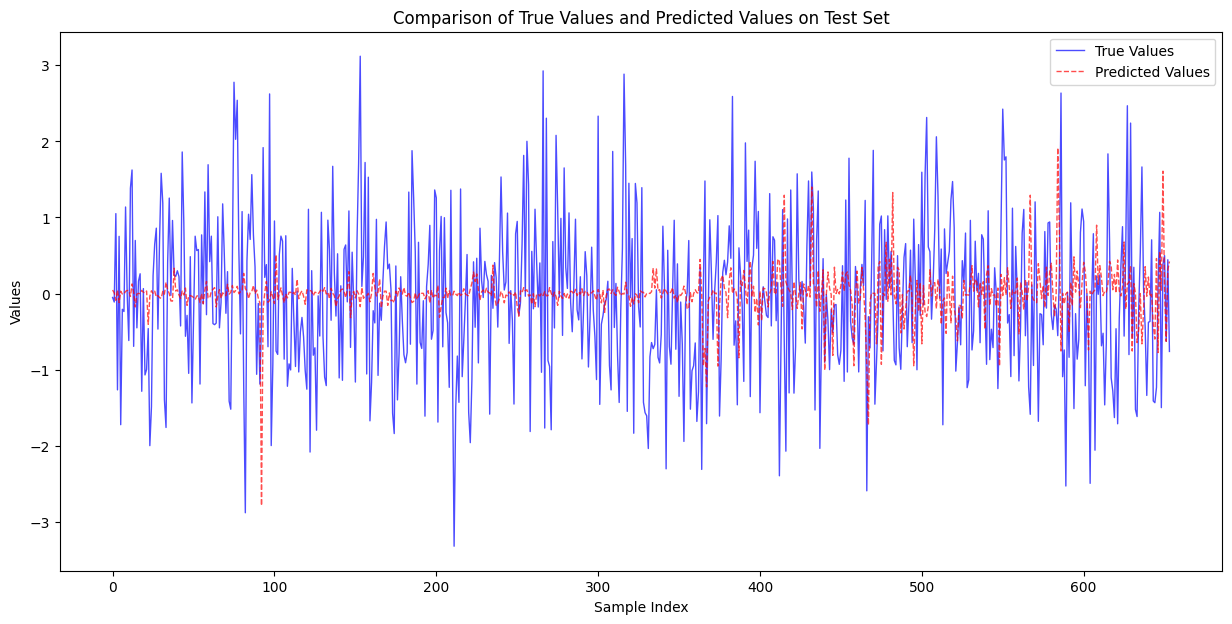

In [6]:

from scipy.stats import spearmanr

y_test_fr_pred = regr.predict(x_test_fr_std)
y_test_de_pred = regr_de.predict(x_test_de_std)

Y_test_fr_target = y_test_fr['TARGET'].values
Y_test_de_target = y_test_de['TARGET'].values


Y_test_combined_pred = np.concatenate((y_test_fr_pred, y_test_de_pred))


Y_test_combined_target = np.concatenate((Y_test_fr_target, Y_test_de_target))

mse_test_combined = mean_squared_error(Y_test_combined_target, Y_test_combined_pred)

spearman_corr_test_combined, _ = spearmanr(Y_test_combined_target, Y_test_combined_pred)

print(f"Combined MSE on test set: {mse_test_combined}")
print(f"Combined Spearman Correlation between actual and predicted values on test set: {spearman_corr_test_combined}")

plt.figure(figsize=(15, 7))

plt.plot(Y_test_combined_target, label='True Values', color='blue', linestyle='-', linewidth=1, alpha=0.7)

plt.plot(Y_test_combined_pred, label='Predicted Values', color='red', linestyle='--', linewidth=1, alpha=0.7)

plt.legend()

plt.title('Comparison of True Values and Predicted Values on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('Values')

plt.show()
